### Import packages & libraries

In [39]:
# Import libraries necessary for this project
import numpy as np   # linear algebra
from numpy import mean
from numpy import std
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from time import time
from tqdm import tqdm
import math
import gc
import os   # accessing directory structure
import requests
from io import StringIO 

# Import visualisation libraries
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')   # Define a plotting style to be used for all plots in this notebook
from mpl_toolkits.mplot3d import Axes3D

# Pretty display for notebooks
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Import Sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor


# Import further data processing algorithms
import lightgbm as lgbm   # (Note: run following codes in your terminal first: pip install --upgrade pip, pip install --upgrade wheel, pip install --upgrade setuptools
import xgboost as xgb 
import catboost as cat
from catboost import CatBoostRegressor, Pool, CatBoostClassifier

RSEED=50

---
### Import Train and Test datasets

In [2]:
train = pd.read_csv("data/Train.csv")
test = pd.read_csv("data/Test.csv")
sample_sub = pd.read_csv("data/sample_sub.csv")
airqo_metadata = pd.read_csv("data/airqo_metadata.csv")


In [3]:
# Airqo_metada provides additional background information about the location (A->E) and features of the parish in which each sensor is located
airqo_metadata.head()

,Unnamed: 0,location,loc_altitude,km2,aspect,dist_motorway,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste
0,0,A,1122.4,1.9,194.0,NaN,NaN,14.695789,343.595039,575.917422,330.609776,254.307415,4763,809,508,43,142
1,1,B,1155.4,5.4,219.8,NaN,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809,22243,5735,116,1144,239
2,2,C,1178.3,8.5,168.7,NaN,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350,97895,26873,21316,751,9835
3,3,D,980.8,0.8,90.0,NaN,NaN,265.896472,NaN,339.693908,76.024389,11.601442,3596,663,7,651,99
4,4,E,1186.5,1.6,121.0,NaN,850.423131,NaN,1738.872942,137.722087,449.591885,3.836589,6064,1297,985,26,43


In [4]:
train.head(20)

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750
5,ID_train_10000,E,"26.225,26.25,26.95833333,27.925,28.41666667,27...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.7566666670000001,0.7090833329999999,0.632,0....","nan,104.3737208,161.28512859999995,161.3224336...","nan,1.4858333330000002,1.090833333,0.941666667...","88.56583333,88.55,88.50916667,88.44083333,88.3...",17.005000
6,ID_train_10001,C,"21.86666667,21.38333333,20.75,20.74166667,20.5...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.548333333,0.571666667,0.589166667,0.57,0.558...","334.0827161,332.4037603,328.58290530000005,332...","1.1525,1.055,1.11,1.385833333,1.2,1.250833333,...","87.73666667,87.74416667,87.7475,87.78,87.84833...",53.100000
7,ID_train_10002,A,"28.24166667,27.9,26.45833333,24.31666667,23.92...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.52725,0.515833333,0.585916667,0.6965,0.72125...","328.4616193,336.5790368000001,346.5753952,18.8...","1.926666667,1.635,0.744166667,0.454166667,0.44...","88.01416667,88.01166667,88.0375,88.13083333,88...",55.051143
8,ID_train_10003,A,"19.08333333,21.06666667,23.00833333,23.85,24.7...","0.017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737,3....","0.974916667,0.93025,0.842583333,0.78475,0.7673...","281.6278307,330.0441836,329.6658617,336.967548...","0.434166667,0.715,1.265833333,1.374166667,1.12...","88.43416667,88.4925,88.5075,88.50083333,88.427...",205.215333
9,ID_train_10004,B,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",25.580541


In [5]:
train.shape

(15539, 9)

In [6]:
# covert features  fronm string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature]=test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])    

In [7]:
train.head()
# It seems that the time series of each weather factor is stored as comma separated string

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",45.126304
1,ID_train_1,D,"[22.53333333, 21.71666667, 20.83333333, 20.983...","[0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...","[0.744583333, 0.808083333, 0.911166667, 0.9163...","[281.6643101, 89.15629262, 81.96853891, 291.01...","[2.3775, 1.126666667, 0.700833333, 0.341666667...","[90.32, 90.3775, 90.44083333, 90.4725, 90.4541...",79.131702
2,ID_train_10,A,"[28.975, 27.95, 29.6, 26.425, 22.09166667, 21....","[0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...","[0.573333333, 0.597166667, 0.5668333329999999,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[88.55166667, 88.46416667, 88.31916667, 88.24,...",32.661304
3,ID_train_100,A,"[22.96666667, 24.26666667, 25.275, 25.625, 25....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...","[0.8430833329999999, 0.79025, 0.7375, 0.728, 0...","[300.0850574, 293.6769595, 294.5174647, 301.92...","[1.446666667, 1.1925, 1.324166667, 1.544166666...","[88.615, 88.53083333, 88.4, 88.27166667, 88.20...",53.850238
4,ID_train_1000,A,"[21.875, 21.575, 21.525, 21.43333333, 20.50833...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8564166670000001, 0.874916667, 0.879833333,...","[21.83997432, 17.05405341, 89.26406044, 123.58...","[0.1975, 0.244166667, 0.411666667, 0.56, 0.577...","[88.55666667, 88.64083333, 88.65833333, 88.647...",177.418750


In [8]:
test.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press
0,ID_test_0,C,"[23.96666667, 22.88333333, 22.28333333, 21.483...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6898333329999999, 0.722333333, 0.7755833329...","[290.1352379, 328.47011289999995, 323.5730796,...","[0.6333333329999999, 0.725, 0.955, 0.8725, 0.6...","[87.64333333, 87.67, 87.70583333, 87.75083333,..."
1,ID_test_1,C,"[18.99166667, 19.70833333, 20.95833333, 22.783...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.99975, 0.99725, 0.956333333, 0.851583333, 0...","[295.2350543, 307.6569135, 313.7360236, 311.51...","[0.640833333, 1.244166667, 1.284166667, 1.2875...","[87.8925, 87.95666667, 87.9925, 87.9925, 87.98..."
2,ID_test_10,D,"[25.11666667, 25.08333333, 24.40833333, 23.575...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.760166667, 0.733583333, 0.78475, 0.82583333...","[77.06161145, 95.48124997, 61.44498258, 89.468...","[2.0133333330000003, 1.3025, 0.783333333, 0.53...","[90.34, 90.2975, 90.305, 90.35583333, 90.4425,..."
3,ID_test_100,C,"[18.71666667, 20.60833333, 22.28333333, 23.983...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.604...","[0.951416667, 0.92575, 0.8603333329999999, 0.7...","[310.7509058, 316.186793, 324.8167326, 327.217...","[0.745, 1.169166667, 1.316666667, 1.385, 1.400...","[87.98833333, 88.06333333, 88.07833333, 88.036..."
4,ID_test_1000,D,"[17.63333333, 18.05833333, 19.625, 21.28333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9, 0.898333333, 0.8725, 0.831666667, 0.8208...","[334.6054069, 329.6848561000001, 322.7668036, ...","[0.620833333, 0.5, 0.456666667, 0.558333333, 1...","[90.515, 90.5575, 90.62333333, 90.6825, 90.679..."


### Features engineering

In [9]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [10]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

['ID',
 'location',
 'temp',
 'precip',
 'rel_humidity',
 'wind_dir',
 'wind_spd',
 'atmos_press',
 'target']

In [11]:
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

In [12]:
data.shape

(20574, 735)

In [13]:
len(data.precip[10])

121

In [14]:
for col_name in tqdm(features):
    data[col_name]=data[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


In [15]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


In [16]:
data.drop(features,1,inplace=True)

In [17]:
train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isna()].reset_index(drop=True)

In [18]:
del data  
gc.collect()

0

Each sample in both train and test provided datasets has a 121 hour readings of weather factors including:

- Temperature
- Percipiation
- Relative humidity
- Wind speed 
- Wind direction
- Atmospheric pressure

The readings are recorded from 5 different locations in Uganda.

In [19]:
train.head()

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_train_0,C,45.126304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155268,0.666250,1.355000,87.871667,87.614167,87.752434,0.070374,0.004952,87.762083,0.257500
1,ID_train_1,D,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
2,ID_train_10,A,32.661304,28.975000,0.000,0.573333,NaN,NaN,88.551667,27.950000,...,0.342484,0.942500,2.420000,88.813333,87.982500,88.420931,0.179481,0.032213,88.425000,0.830833
3,ID_train_100,A,53.850238,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,24.266667,...,0.336701,1.388333,2.469167,88.685000,87.965000,88.376915,0.161758,0.026166,88.400000,0.720000
4,ID_train_1000,A,177.418750,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,21.575000,...,0.181690,0.542917,1.796667,88.719167,88.268333,88.538104,0.118369,0.014011,88.552500,0.450833


In [20]:
test.head()

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_test_0,C,NaN,23.966667,0.0,0.689833,290.135238,0.633333,87.643333,22.883333,...,0.154279,0.767500,1.744167,88.020833,87.474167,87.748506,0.132764,0.017626,87.752500,0.546667
1,ID_test_1,C,NaN,18.991667,0.0,0.999750,295.235054,0.640833,87.892500,19.708333,...,0.208605,0.771667,1.889167,88.181667,87.572500,87.936963,0.113756,0.012940,87.928333,0.609167
2,ID_test_10,D,NaN,25.116667,0.0,0.760167,77.061611,2.013333,90.340000,25.083333,...,0.324600,0.567500,2.890000,90.785000,90.115000,90.521357,0.136316,0.018582,90.536667,0.670000
3,ID_test_100,C,NaN,18.716667,0.0,0.951417,310.750906,0.745000,87.988333,20.608333,...,0.185370,0.685000,1.575000,88.078333,87.560000,87.754848,0.125583,0.015771,87.726667,0.518333
4,ID_test_1000,D,NaN,17.633333,0.0,0.900000,334.605407,0.620833,90.515000,18.058333,...,0.193861,0.609091,1.761667,90.798333,90.105833,90.475030,0.161193,0.025983,90.487273,0.692500


In [21]:
# Print shape of datasets
print('Train data')
print('# df_train:   {}'.format(train.shape))
print('==================')
print('Test data')
print('# df_test:    {}'.format(test.shape))

Train data
# df_train:   (15539, 771)
Test data
# df_test:    (5035, 771)


---
### (Optional) Merging airqo and train data (tbd)
-> not sure if this step is necessary <br>
-> You have to perform a left join with the original dataframe by using location as the key. Obviously the NaN values will be replicated after joining.

---
### Encoding variable 'location' (tbc)

In [22]:
# It encodes labels with value between 0 and n_classes-1
#This transformer should be used to encode target values, i.e. y, and not the input X (ask the coaches)

from sklearn.preprocessing import LabelEncoder
lab  = LabelEncoder()

lab.fit(train["location"])

train.location  = lab.transform(train.location)
test.location  = lab.transform(test.location)

train.target.min(),train.target.max()

(1.4526190476190477, 475.82)

A -> 0 <br>
B -> 1 <br>
C -> 2 <br>
D -> 3 <br>
E -> 4

In [23]:
train.head(8)

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_train_0,2,45.126304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155268,0.666250,1.355000,87.871667,87.614167,87.752434,0.070374,0.004952,87.762083,0.257500
1,ID_train_1,3,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
2,ID_train_10,0,32.661304,28.975000,0.000,0.573333,NaN,NaN,88.551667,27.950000,...,0.342484,0.942500,2.420000,88.813333,87.982500,88.420931,0.179481,0.032213,88.425000,0.830833
3,ID_train_100,0,53.850238,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,24.266667,...,0.336701,1.388333,2.469167,88.685000,87.965000,88.376915,0.161758,0.026166,88.400000,0.720000
4,ID_train_1000,0,177.418750,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,21.575000,...,0.181690,0.542917,1.796667,88.719167,88.268333,88.538104,0.118369,0.014011,88.552500,0.450833
5,ID_train_10000,4,17.005000,26.225000,0.000,0.756667,NaN,NaN,88.565833,26.250000,...,0.282313,1.075000,3.122500,88.746667,88.097500,88.437645,0.147604,0.021787,88.420833,0.649167
6,ID_train_10001,2,53.100000,21.866667,0.000,0.548333,334.082716,1.152500,87.736667,21.383333,...,0.198869,0.893333,1.884167,87.961667,87.472500,87.717645,0.121492,0.014760,87.729167,0.489167
7,ID_train_10002,0,55.051143,28.241667,0.000,0.527250,328.461619,1.926667,88.014167,27.900000,...,0.226285,0.716667,1.919167,88.511667,87.838333,88.212652,0.169373,0.028687,88.235000,0.673333


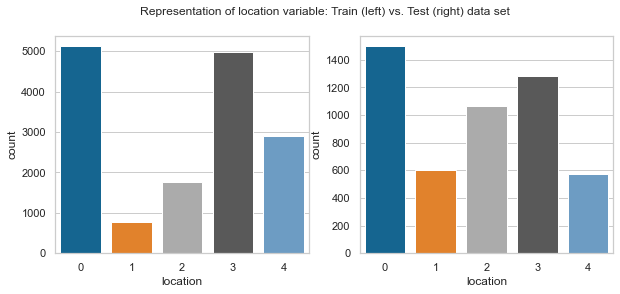

In [24]:
# Visualize frequency of variable 'location' on y_train and y_test datasets
# As shown, numbers of entries in DF with respect of the location are unequal

fig, axes = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle("Representation of location variable: Train (left) vs. Test (right) data set")
sns.countplot(x=train['location'], ax=axes[0]);
sns.countplot(x=test['location'], ax=axes[1]);

--- 
### Defining features and target variables - Train-Test split

The target variable of each sample represents PM2.5 index measured 24 hours after the last weather readings

In [25]:
X_train = train.drop(['ID', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['ID', 'target'], axis=1)
y_test = test['target']

--- 
### Carry out first EDA on training data

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15539 entries, 0 to 15538
Columns: 771 entries, ID to ptp_atmos_press
dtypes: float64(769), int64(1), object(1)
memory usage: 91.4+ MB


In [27]:
train.shape

(15539, 771)

In [28]:
train.describe()

,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,newprecip1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
count,15539.000000,15539.000000,14486.000000,14453.000000,14491.000000,13795.000000,13795.000000,14528.000000,14494.000000,14463.000000,...,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000
mean,1.986679,58.242429,22.923816,0.175120,0.789958,198.339982,1.043445,89.074832,22.930973,0.176842,...,0.338015,0.925264,2.623182,89.338966,88.698915,89.037603,0.145992,0.021760,89.045986,0.640050
std,1.561175,42.373700,3.614342,1.442712,0.151174,110.402313,0.747569,1.112259,3.612339,1.430508,...,0.308010,0.620622,1.553281,1.099682,1.047869,1.077735,0.021128,0.006442,1.079526,0.111511
min,0.000000,1.452619,13.783333,0.000000,0.251500,0.012510,0.123333,87.250000,13.783333,0.000000,...,0.017159,0.393333,0.509167,87.871667,87.250000,87.605234,0.069121,0.004778,87.597500,0.257500
25%,0.000000,33.482625,19.983333,0.000000,0.684417,106.897407,0.526667,88.285000,19.993750,0.000000,...,0.184630,0.679167,1.845833,88.615000,87.993333,88.338223,0.131391,0.017263,88.351667,0.569167
50%,3.000000,46.504048,22.266667,0.000000,0.819167,193.063223,0.845833,88.509583,22.279167,0.000000,...,0.270154,0.764167,2.354167,88.757500,88.185833,88.476391,0.144987,0.021021,88.482500,0.635833
75%,3.000000,68.569062,25.566667,0.000000,0.912917,306.025223,1.350833,90.455000,25.575000,0.000000,...,0.403447,0.938333,3.067500,90.819167,90.066667,90.479444,0.158946,0.025264,90.490833,0.702500
max,4.000000,475.820000,35.683333,43.080000,1.000000,359.997383,15.607500,91.130833,35.683333,43.080000,...,6.681586,5.613333,24.659167,91.130833,90.503333,90.807583,0.269699,0.072738,90.817500,1.033333


In [29]:
train.columns

Index(['ID', 'location', 'target', 'newtemp0', 'newprecip0',
       'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0',
       'newtemp1',
       ...
       'var_wind_spd', 'median_wind_spd', 'ptp_wind_spd', 'max_atmos_press',
       'min_atmos_press', 'mean_atmos_press', 'std_atmos_press',
       'var_atmos_press', 'median_atmos_press', 'ptp_atmos_press'],
      dtype='object', length=771)

In [30]:
# Print all colums variables as a list
# print(train.columns.values.tolist())

In [ ]:
#print(train['ID'].tolist())

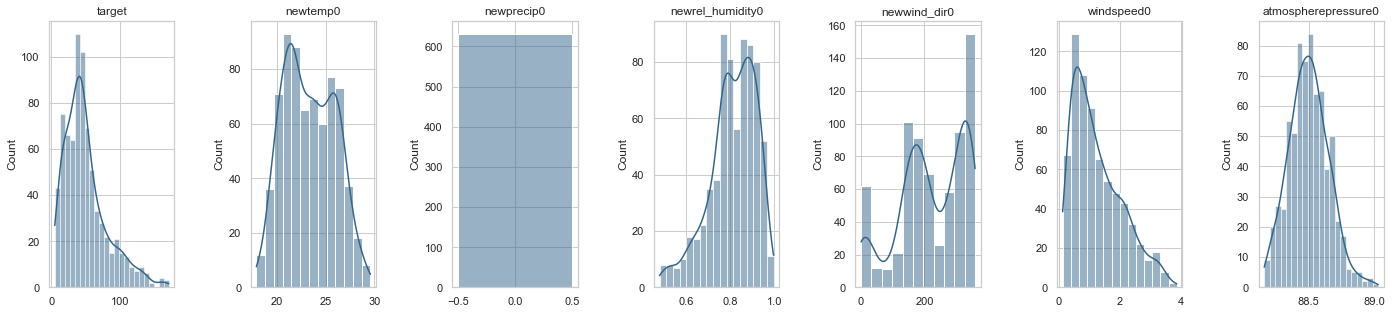

In [32]:
# Discuss with Martins if this plot is useful somehow for our analysis.....
# Plot distribution of features for only one data entry, e.g. <variablename_0>, including the target variable
# Plot will be make for only location 0 (A)


plot_col = ['target', 'newtemp0', 'newprecip0', 'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0']
fig,ax = plt.subplots(1, 7,figsize=(20,5))
count = 0
for col in plot_col:
    sns.histplot(train.query("location==1")[col], kde=True, ax=ax[count], color='#33658A').set(title=col, xlabel='')
    count += 1
fig.tight_layout(pad=3)

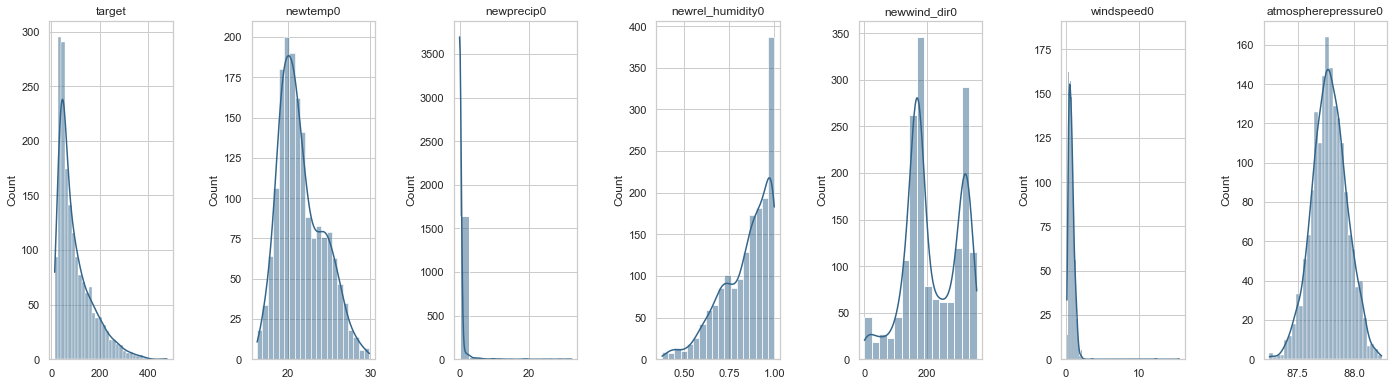

In [33]:
# Here example for location == 2 (C)
plot_col = ['target','newtemp0', 'newprecip0', 'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0']
fig,ax = plt.subplots(1, 7,figsize=(20,6))
count = 0
for col in plot_col:
    sns.histplot(train.query("location==2")[col], kde=True, ax=ax[count], color='#33658A').set(title=col, xlabel='')
    count += 1
fig.tight_layout(pad=3)

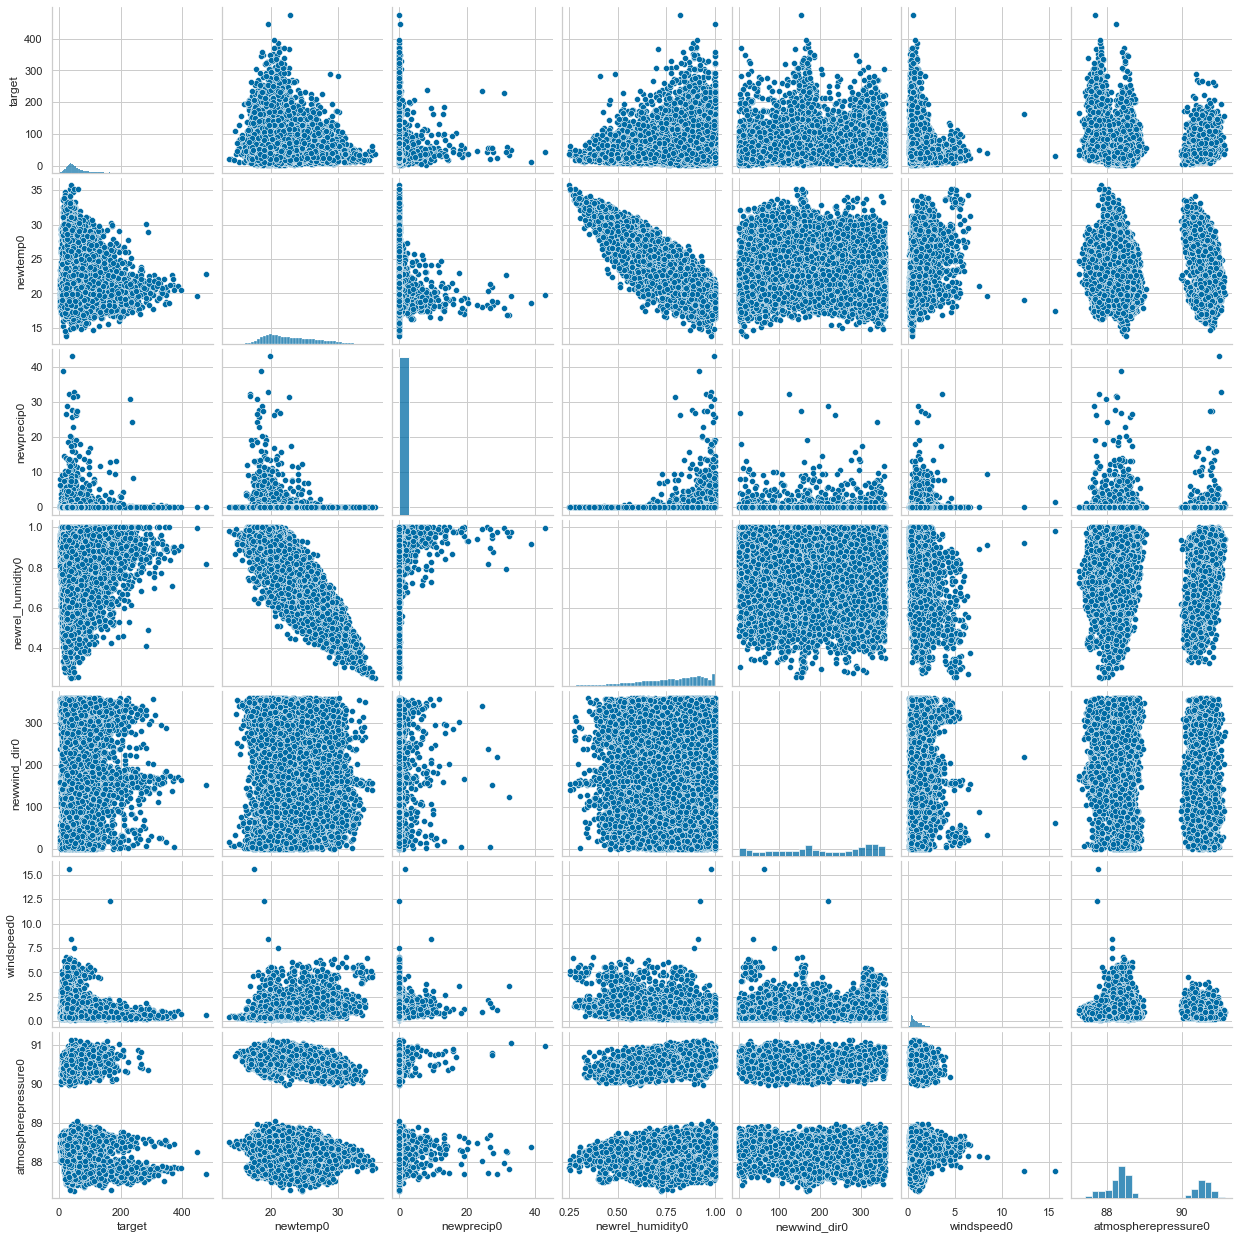

In [34]:
# Ploting and calculating correlations between features
# example plot for only one time stamp entry

sns.pairplot(train[['target', 'newtemp0', 'newprecip0', 'newrel_humidity0', 'newwind_dir0', 'windspeed0', 'atmospherepressure0']]);

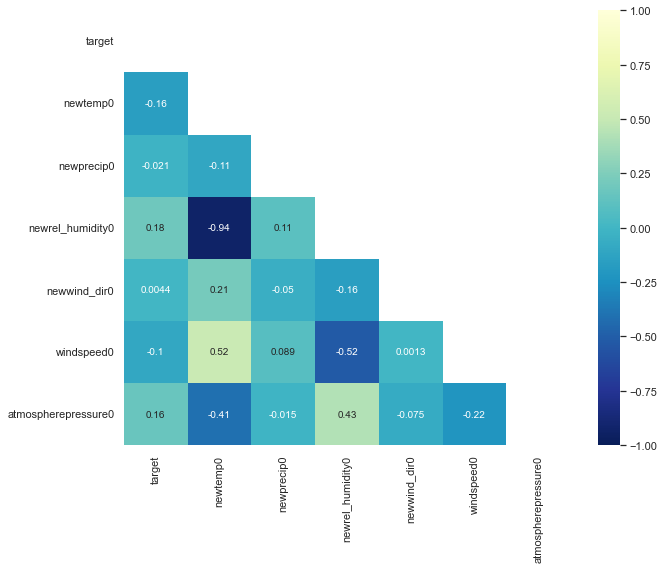

In [35]:
# Calculate correlations between features and target, only for one time stamp measured entry
train_A = train.query("location == 0")
train_A = train_A.iloc[:,2:9]

corr = train_A.corr()

plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap="YlGnBu_r", mask=mask, vmax=1, vmin=-1);

NameError: name 'train_time_series_feat' is not defined

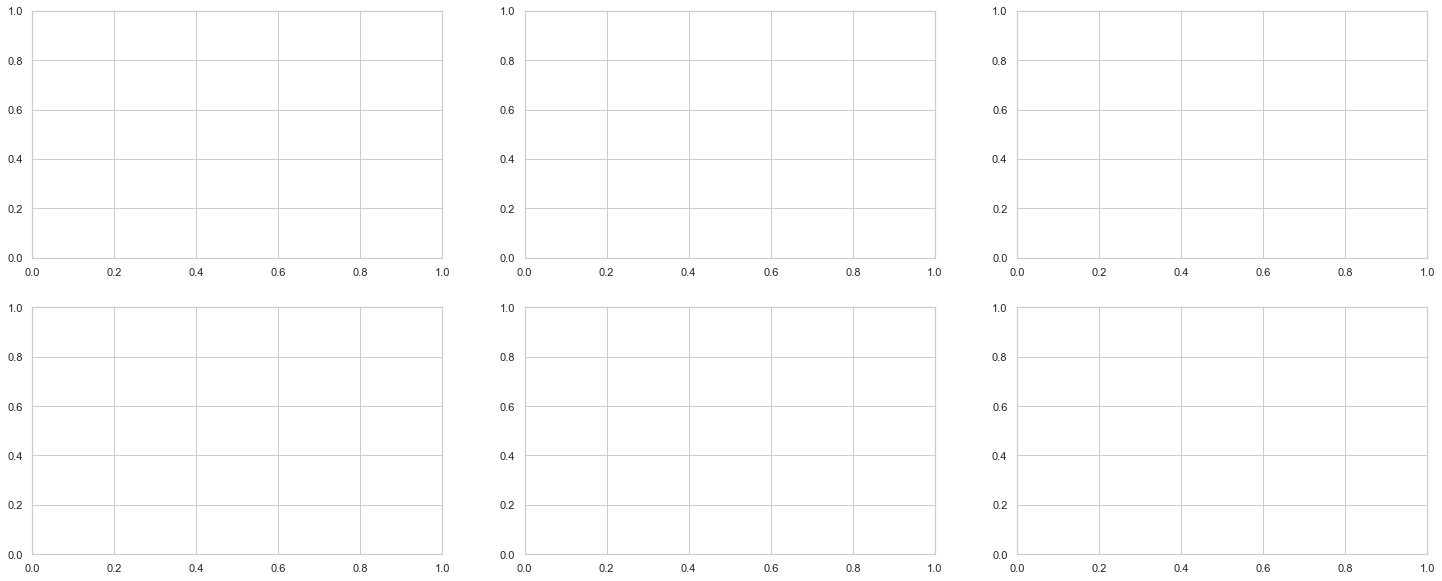

In [36]:
# plot the histogram of each weather factor

rng = np.arange(121)

fig, axs = plt.subplots(2, 3, figsize=(25,10))

valid_idx = np.where(train_time_series_feat[:,:,0] != -100)
axs[0, 0].hist(train_time_series_feat[:,:,0][valid_idx].flatten(), bins=100)
axs[0, 0].set(xlabel='Temp', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,1] != -100)
axs[0, 1].hist(train_time_series_feat[:,:,1][valid_idx].flatten(), bins=100)
axs[0, 1].set(xlabel='Percipiation', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,2] != -100)
axs[0, 2].hist(train_time_series_feat[:,:,2][valid_idx].flatten(), bins=100)
axs[0, 2].set(xlabel='Relative humidity', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,3] != -100)
axs[1, 0].hist(train_time_series_feat[:,:,3][valid_idx].flatten(), bins=100)
axs[1, 0].set(xlabel='Wind Direction', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,4] != -100)
axs[1, 1].hist(train_time_series_feat[:,:,4][valid_idx].flatten(), bins=100)
axs[1, 1].set(xlabel='Wind Speed', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,5] != -100)
axs[1, 2].hist(train_time_series_feat[:,:,5][valid_idx].flatten(), bins=100)
axs[1, 2].set(xlabel='Atmospheric Pressure', ylabel='Number of samples')


fig.suptitle('Histograms of Weather Factors')
print()

--- 
### (Optional) Adjust the data frame (tbd)

In [ ]:
# Getting smaller train data frame with only location==A
#train_A = train.query("location == 'A'")
#train_A.shape

In [ ]:
# Slicing the train data frame, taking only the first 20 columns
#train_A = train_A.iloc[:,750:771]
#train_A.head()

In [ ]:
#print(train_A['ID'].tolist())

--- 
### Imputing NaN values

- Since the data is a hourly average of weather indicators for 5 days (total 121 hours), a good approach might be for dealing with such NaN values 
is by looping through the list and averaging it on hour basis, maybe 8 hours interval or so
- On the other hand, it is better to not include more noise to the model and not fill null values with mean, median, mode in this particular problem statement
- IN addition, if the selected model is lightgbm or similar packages (Boosting methods) they can handle NaN values by default quite well, for this reason we would suggest to leave them as it is

In [ ]:
train.isnull().sum().sort_values(ascending=False)

---
### Scaling the data
Discuss with Martins if this step is needed in our case, maybe not since we are not imputing the NaN values<br>
Scaling to be applied only to the features. Two option are available: normalization and standardization

In [ ]:
# Code example for Standardizing the features
# Standardizing the data
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

---
### Histogram

In [ ]:
rng = np.arange(121)

fig, axs = plt.subplots(2, 3, figsize=(25,10))

valid_idx = np.where(train[:,:,0] != -100)
axs[0, 0].hist(train[:,:,0][valid_idx].flatten(), bins=100)
axs[0, 0].set(xlabel='Temp', ylabel='Number of samples')
valid_idx = np.where(train[:,:,1] != -100)
axs[0, 1].hist(train[:,:,1][valid_idx].flatten(), bins=100)
axs[0, 1].set(xlabel='Precipitation', ylabel='Number of samples')
valid_idx = np.where(train[:,:,2] != -100)
axs[0, 2].hist(train[:,:,2][valid_idx].flatten(), bins=100)
axs[0, 2].set(xlabel='Relative humidity', ylabel='Number of samples')
valid_idx = np.where(train[:,:,3] != -100)
axs[1, 0].hist(train[:,:,3][valid_idx].flatten(), bins=100)
axs[1, 0].set(xlabel='Wind Direction', ylabel='Number of samples')
valid_idx = np.where(train[:,:,4] != -100)
axs[1, 1].hist(train[:,:,4][valid_idx].flatten(), bins=100)
axs[1, 1].set(xlabel='Wind Speed', ylabel='Number of samples')
valid_idx = np.where(train[:,:,5] != -100)
axs[1, 2].hist(train[:,:,5][valid_idx].flatten(), bins=100)
axs[1, 2].set(xlabel='Atmospheric Pressure', ylabel='Number of samples')


fig.suptitle('Histograms of Weather Factors')
print()

---
### Ideas for plotting (tbc)

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

--- 
### Replacing NaN using pipelines

In [ ]:
# It runs forever, better not to use it

pipe = Pipeline((
("it", IterativeImputer()),
("pt", PowerTransformer()),
("sc", StandardScaler()),
("xb", xgb()),
#("kn", KNeighborsClassifier()),
#("dt", DecisionTreeClassifier(random_state=RSEED))
))
pipe.fit(X_train,y_train)
print("Testing Accuracy : ", pipe.score(X_test,y_test))
print("Training Accuracy: ", pipe.score(X_train,y_train))

---
## Predictive Modeling building and testing

Before start modelling it is a best practice to define a evaluation metric most appropriate for our case. In our challenge, the RMSE is already given as part of the requirements by ZINDI

---
### Baseline Model
This baseline model represents a educated guess and acts as a benchmark for any further models to beat. 

...From the exploration of our data we can see that the glucose value is a good indicator if someone has diabetes or not. We will choose a value of 130 as the cutoff. For our baseline model we will predict that everyone with a glucose value higher than 130 suffers from diabetes...

In [43]:
# given by Martins 

y_pred_b = y_train.mean()
y_pred_b2 = [y_pred_b]* len(y_train)

mean_sqrd_e = mean_squared_error(y_test,y_pred_b2)

RMSE = sqrt(mean_sqrd_e)

ValueError: Found input variables with inconsistent numbers of samples: [5035, 15539]

In [48]:
# Get NaN
train.isnull().sum().sort_values(ascending=False). head()

newwind_dir0    1744
windspeed0      1744
newwind_dir1    1730
windspeed1      1730
newwind_dir2    1721
dtype: int64

In [54]:
# Replace NaN values only for the dummy regressor

# Replace missing values in train set with median from train set
values_dict = {}
for col in plot_col:
    train[col] = train[col].fillna(train[col].mean())
    #train[col] = train[col].fillna(values_dict[col])
    
train.isnull().sum().sort_values(ascending=False)

windspeed1         1730
newwind_dir1       1730
windspeed2         1721
newwind_dir2       1721
newwind_dir3       1708
                   ... 
std_precip            0
var_precip            0
median_precip         0
ptp_precip            0
ptp_atmos_press       0
Length: 771, dtype: int64

In [53]:
train

,ID,location,target,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,newtemp1,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
0,ID_train_0,2,45.126304,22.923816,0.17512,0.789958,198.339982,1.043445,89.074832,NaN,...,0.155268,0.666250,1.355000,87.871667,87.614167,87.752434,0.070374,0.004952,87.762083,0.257500
1,ID_train_1,3,79.131702,22.533333,0.10200,0.744583,281.664310,2.377500,90.320000,21.716667,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
2,ID_train_10,0,32.661304,28.975000,0.00000,0.573333,198.339982,1.043445,88.551667,27.950000,...,0.342484,0.942500,2.420000,88.813333,87.982500,88.420931,0.179481,0.032213,88.425000,0.830833
3,ID_train_100,0,53.850238,22.966667,0.00000,0.843083,300.085057,1.446667,88.615000,24.266667,...,0.336701,1.388333,2.469167,88.685000,87.965000,88.376915,0.161758,0.026166,88.400000,0.720000
4,ID_train_1000,0,177.418750,21.875000,0.00000,0.856417,21.839974,0.197500,88.556667,21.575000,...,0.181690,0.542917,1.796667,88.719167,88.268333,88.538104,0.118369,0.014011,88.552500,0.450833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15534,ID_train_9995,0,44.850286,22.716667,31.46700,0.794091,198.339982,1.043445,88.276667,16.933333,...,0.234138,0.890000,2.194167,88.730000,87.890833,88.382934,0.187366,0.035106,88.393333,0.839167
15535,ID_train_9996,4,24.330455,25.375000,0.00000,0.685333,176.543826,1.328333,88.436667,26.025000,...,0.385348,1.094167,2.330833,88.704167,88.082500,88.435840,0.141562,0.020040,88.450000,0.621667
15536,ID_train_9997,3,38.972128,26.091667,0.00000,0.781750,121.706016,0.936667,90.615833,28.975000,...,0.389128,0.897500,3.608333,90.885000,90.145833,90.522397,0.161257,0.026004,90.520000,0.739167
15537,ID_train_9998,3,41.720952,29.225000,0.00000,0.628333,156.475731,1.330833,90.314167,30.000000,...,0.359279,0.828333,2.683333,90.793333,90.106667,90.486202,0.160746,0.025839,90.512500,0.686667


In [52]:
# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')

# fit it on the training set
dummy_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = dummy_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Dummy RMSE:", rmse)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# create a linear regression model
lin_reg = LinearRegression()

# fit on the training data
lin_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = lin_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(mse)
print("Linear Regression RMSE:", lin_rmse)


---
### Cross validation strategy (Kfold,or simple train test split )
Expected results for CV based on ZINDI forum -> 25
We can try Kfold method with 20 folds

In [ ]:
# How to use 

In [ ]:
# coding gave by martins

errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
fold=KFold(n_splits=20)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostRegressor(   n_estimators=500,eval_metric='RMSE',learning_rate=0.2, random_seed= 1234, use_best_model=True )
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)#erly100
    preds=m2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict(test.drop(["ID"],axis = 1))
    y_pred_totcb2.append(p2)
np.mean(errcb2)

--- 
### Hyperparameter Tuning of Light Gradient Boost Model (LGBM)

--- 
### Hyperparameter Tuning of CatBoost

--- 
## Training the model / Model evaluation

In [ ]:

#y_train_pred = reg.predict(X_train)
#mse = mean_squared_error(y_train, y_train_pred)
#print(mse)

#sklearn.metrics has a mean_squared_error function with a squared kwarg (defaults to True). Setting squared to False will return the RMSE.

In [ ]:
#training the model
#from sklearn.linear_model import LinearRegression
#reg = LinearRegression().fit(X_train, y_train)

---


In [ ]:
# example coming from starterNotebook

try : 
    folds=pd.read_csv("./proc_data/folds_id.csv")
    train=train.merge(folds,on="ID",how="left")
    train.fold.nunique()
except : 
    #  you run this cell  only for the first time 
    from sklearn.model_selection import KFold 
    kfold=KFold(n_splits=5,shuffle=True,random_state=2020) # change this random_state or all of you will have the same score  :D 
    train.reset_index(drop=True,inplace=True)
    folds=train[["ID"]].copy()
    folds["fold"]=0
    for fold,(tr_indx,val_ind) in enumerate(kfold.split(folds)) : 
        folds.loc[val_ind,"fold"]=fold
    folds.to_csv("./proc_data/folds_id.csv",index=False)
    train=train.merge(folds,on="ID",how="left")
    
    del folds

---
### Ensemble Model
Winner -> algorithm is an LGBM + CATBOOST ensemble.......with Light Gradient Boost Model (LGBM) as the base model and CatBoost model as the meta-learner <br>
Rank 8 ->  XGB + LGB + CA....


Several algoritms are used to carry out a predictive modeling (regression OR classifier). In this case, we decided to treat the problem as a pseudo time-series where the algorithm learns the temporal nature of the data without any timestamp given. For this purpose, we utilize the idx features derived from the indices (positions) of the data points in their respective 5-day series using a stacked model to better learn the relationship between the meteorological variables and targ...

In [ ]:
#Example for setting a Stacking ensemble method for regression:

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

---
### Metric evaluation (RMSE)

In [ ]:
from sklearn.metrics import mean_squared_error
def metric(y,x):
    return np.sqrt(mean_squared_error(x,y))

# solution with an rmse at least 38.42

In [ ]:
def train_function(model,train,test,params,other_params,target_name,features,metric):
    folds_num=train.fold.nunique()
    validation=train[[id_name,"fold",target_name]].copy()
    validation["pred_"+target_name]=0
    sub=test[[id_name]].copy()
    sub[target_name]=0
    for fold in np.sort(train.fold.unique()):
        print("#"*50+" {} ".format(fold)+"#"*50)
        os.makedirs("model_save/lgbm/{}/{}".format(Experiment_name,str(int(fold))), exist_ok=True)
        X_train=train[train.fold!=fold]
        X_val=train[train.fold==fold]
        
        train_pred,validation_pred,test_pred=model(X_train,X_val,test,params,other_params)
        
        validation.loc[validation.fold==fold,"pred_"+target_name]=validation_pred
        sub[target_name]+=test_pred/folds_num
        train_score=metric(X_train[target_name],train_pred)
        val_score=metric(X_val[target_name],validation_pred)
        print("train score : {} validation score : {}".format(round(train_score,4),round(val_score,4)))
    final_validation_score=metric(validation[target_name],validation["pred_"+target_name])
    print("final validation score : {}".format(final_validation_score))
        
    return sub,validation,final_validation_score

def lgbm_model(X_train,X_val,X_test,params,other_params):
    dtrain = lgbm.Dataset(data=X_train[features], label=X_train[target_name], feature_name=features)
    dval = lgbm.Dataset(data=X_val[features], label=X_val[target_name], feature_name=features)

    model = lgbm.train(
        params=params,
        train_set=dtrain,
        num_boost_round=other_params["num_boost_round"],
        valid_sets=(dtrain, dval),
        early_stopping_rounds=other_params["early_stopping_rounds"],
        verbose_eval=other_params["verbose_eval"],
    )        
    best_iteration = model.best_iteration
    train_pred=model.predict(X_train[features], num_iteration=best_iteration)
    validation_pred=model.predict(X_val[features], num_iteration=best_iteration)
    test_pred=model.predict(test[features], num_iteration=best_iteration)
        
    return train_pred,validation_pred,test_pred

In [ ]:
other_params={"num_boost_round":50000000,
              "early_stopping_rounds":50,
              "verbose_eval":1000,
}
lgbm_params = {
    "bagging_fraction": 0.8,
    "bagging_freq": 2,
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,
    "learning_rate": 0.01,
    "max_depth": 8,
    "num_threads": 16,
    "objective": "regression",
    "metric": "rmse",
    "seed": 2020,
}

In [ ]:
sub,validation,score=train_function(model=lgbm_model,
                                    train=train,
                                    test=test,
                                    params=lgbm_params,
                                    other_params=other_params,
                                    target_name=target_name,
                                    features=features,
                                    metric=metric)

In [ ]:
os.makedirs("subs", exist_ok=True)

In [ ]:
sub.to_csv("./subs/lgbm_{}.csv".format(round(score,2)),index=False)